# Dask processing tests

this needs graphviz for visualizations

In [1]:
import dask
import dask.array as da
import numpy as np


## define a computational graph
embarassingly parallel here 

In [2]:
def f(x):
    return x + 1

def g(x):
    return x * 2

def h(x):
    return x - 3

def m(x):  
    return da.mean(x)  # we can also use numpy.mean here if we want, but the latter will directly materialize the array. da.mean needs a 'compute' call to materialize the array instead

def identity(x):
    return x

In [3]:
f_delayed = dask.delayed(f)
g_delayed = dask.delayed(g)
h_delayed = dask.delayed(h)
m_delayed = dask.delayed(m)

In [4]:
input_placeholder = dask.delayed(identity, pure = True)(da.arange(2))
fx = f_delayed(input_placeholder)
gx = g_delayed(fx)
hx = h_delayed(gx)
mx = m_delayed(hx)
input_key = input_placeholder.key
computation = mx 
graph = dict(computation.dask)

In [5]:
input_key

'identity-a6a84f881da07f5791b1695d91e07114'

In [6]:
computation

Delayed('m-03bb9dcd-5cdd-4624-a89b-8c43fac703bd')

In [7]:
graph

{'identity-a6a84f881da07f5791b1695d91e07114': <Task 'identity-a6a84f881da07f5791b1695d91e07114' identity(...)>,
 'arange-finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a-12e602f8a22a45c79e8d80cf3bb58d9b': <Task 'arange-finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a-12e602f8a22a45c79e8d80cf3bb58d9b' _identity(...)>,
 'finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a-12e602f8a22a45c79e8d80cf3bb58d9b': <Task 'finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a-12e602f8a22a45c79e8d80cf3bb58d9b' _identity(...)>,
 'arange-finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a': <Task 'arange-finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a' _execute_subgraph(...)>,
 'finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a': Alias('finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a'->'arange-finalize-hlgfinalizecompute-c009a5b62dd84ef1acd4f7515572a97a'),
 'f-ffbb7747-1ddf-4591-a8b1-8803a591a28d': <Task 'f-ffbb7747

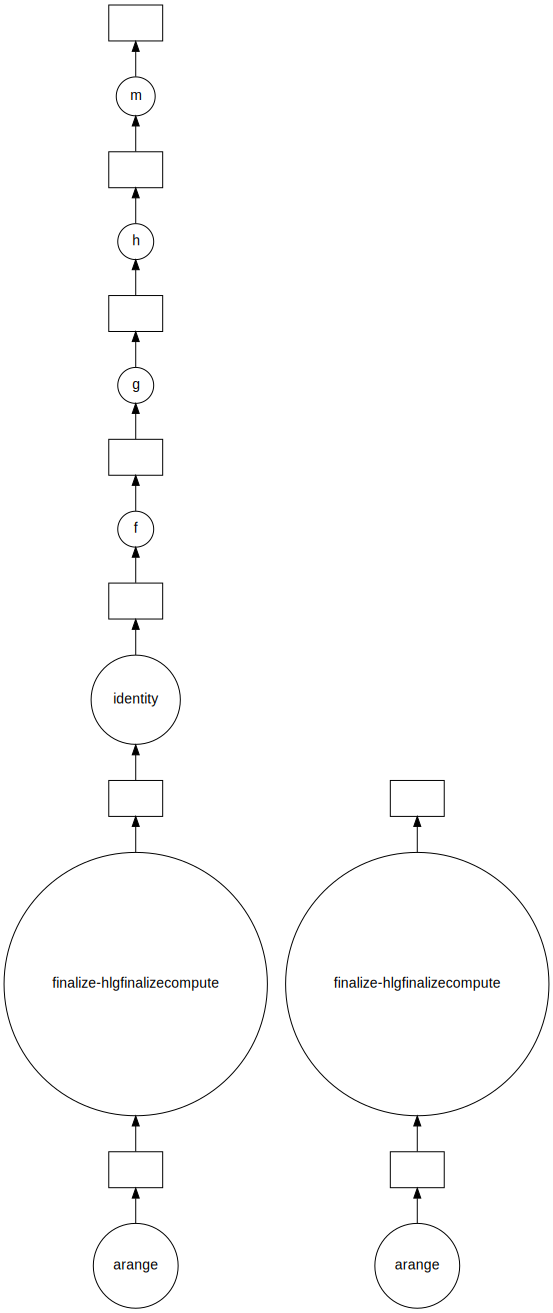

In [8]:
dask.visualize(computation, filename='dask_graph.svg', format='svg')
# Save the graph to a file

### Execute with dask

replace input with something more supstantial

In [9]:
og_data = np.random.rand(int(1e9))

wrap numpy array into dask array. only for the experiments here

In [10]:
input_data = da.from_array(og_data, chunks=(int(1e6),))

built the result by hand to be able to check it 

replace input of graph with new input and compute result 

In [11]:
dask.config.set(scheduler='synchronous') # make ALL operations synchronous
graph[input_key] = input_data 
result = dask.get(graph, mx.key,).compute()
result

np.float64(-1.813128511285369e-05)

try with parallel scheduler

In [12]:
dask.config.set(scheduler='processes') 

graph[input_key] = input_data 
result = dask.get(graph, mx.key).compute()  # Use processes scheduler
result

np.float64(-1.813128511285369e-05)

for dataframes, have a look [here](https://examples.dask.org/dataframe.html), for xarray, check [this](https://docs.xarray.dev/en/stable/user-guide/dask.html) out, and [that](https://examples.dask.org/xarray.html?highlight=schedulers) 

## Partial parallelization of a computational graph with `dask.annotate`

annotate `h` to be serial only

In [13]:

def h_single(x): 
    with dask.config.set(scheduler='synchronous'):
        hx =  h(x)
    return hx.rechunk('auto') # re-split the data again to make downstream operations parallel

h_delayed_serial = dask.delayed(h_single)

build up the graph again

In [14]:
input_placeholder = dask.delayed(identity, pure = True)(da.arange(2))
fx = f_delayed(input_placeholder)
gx = g_delayed(fx)
hx = h_delayed_serial(gx) # README: use the serial version of h
mx = m_delayed(hx)
input_key = input_placeholder.key
computation = mx 
graph = dict(computation.dask) 

execute the thing again with a parallel scheduler - check how the CPU load behaves.

In [15]:
dask.config.set(scheduler='processes')  # make operations parallel
graph[input_key] = input_data
result = dask.get(graph, computation.key).compute()  # Use processes scheduler
result

np.float64(-1.8131285112853692e-05)

## Custom dask graph 

In [98]:
import dask

In [100]:
def add(x, y):
    return x + y

def multiply(x, y):
    return x * y

def affine(x, a = 1, b = 0):
    return a * x + b

def save_data(x, filename):
    np.save(filename, x)

def read_data(filename):
    return np.load(filename)

In [108]:
import dask.delayed

tasks = {
    "read": dask.delayed(read_data),
    "add":dask.delayed(add),
    "multiply": dask.delayed(multiply), 
    "affine": dask.delayed(affine),
    "save": dask.delayed(save_data),
}

read_node = tasks['read']("input_data.npy")
add_node = tasks['add'](read_node, 5)
multiply_node = tasks['multiply'](add_node, read_node)
affine_node = tasks['affine'](multiply_node, a=2, b=3)
save_data_node = tasks['save'](affine_node, "output_data.npy")

In [109]:
import numpy as np
input_data = np.random.rand(100) 
np.save("input_data.npy", input_data)

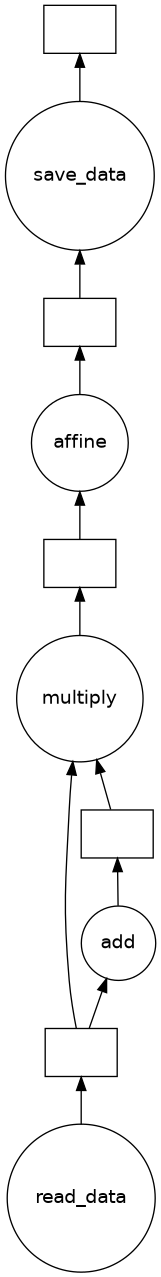

In [110]:
save_data_node.visualize()

In [111]:
save_data_node.compute()

In [112]:
output_data = np.load("output_data.npy")
output_data

array([ 7.10941857,  8.35702935, 14.84886564, 11.38207125,  7.18510619,
        3.66906895, 12.54621128,  4.84411714, 12.36806868,  5.3033671 ,
        8.65103913, 14.87918018,  6.88040144,  5.85718609,  4.79831534,
        8.47431415,  5.87605966,  6.05857219,  3.38954836, 12.73375802,
        9.99786678,  5.54205697,  3.26142386,  5.59803628, 12.87766437,
        5.27220128,  8.28875148,  8.7802487 , 11.75194584, 10.85591605,
        5.35917065, 11.97301705, 11.68508028,  5.03746093,  6.58300293,
       13.58332848, 12.46121247,  5.94672827,  4.15489768,  9.19910626,
        9.15389375,  5.88331414,  8.52920549, 14.85349016,  5.06914026,
        4.49397626,  7.11775551,  7.31329419,  9.01895907,  5.00030313,
        3.54558348,  5.37363946,  6.11949439, 14.20512693, 13.26007235,
        7.03030832,  8.31844485,  3.25476052, 12.55463013,  8.07887098,
        5.94217016, 12.56629472, 14.394822  , 14.62201619, 12.60696562,
       13.37517238, 13.33828332, 11.67503571,  3.6395812 ,  6.61

In [113]:
2 * ((input_data + 5 ) * input_data ) + 3 

array([ 7.10941857,  8.35702935, 14.84886564, 11.38207125,  7.18510619,
        3.66906895, 12.54621128,  4.84411714, 12.36806868,  5.3033671 ,
        8.65103913, 14.87918018,  6.88040144,  5.85718609,  4.79831534,
        8.47431415,  5.87605966,  6.05857219,  3.38954836, 12.73375802,
        9.99786678,  5.54205697,  3.26142386,  5.59803628, 12.87766437,
        5.27220128,  8.28875148,  8.7802487 , 11.75194584, 10.85591605,
        5.35917065, 11.97301705, 11.68508028,  5.03746093,  6.58300293,
       13.58332848, 12.46121247,  5.94672827,  4.15489768,  9.19910626,
        9.15389375,  5.88331414,  8.52920549, 14.85349016,  5.06914026,
        4.49397626,  7.11775551,  7.31329419,  9.01895907,  5.00030313,
        3.54558348,  5.37363946,  6.11949439, 14.20512693, 13.26007235,
        7.03030832,  8.31844485,  3.25476052, 12.55463013,  8.07887098,
        5.94217016, 12.56629472, 14.394822  , 14.62201619, 12.60696562,
       13.37517238, 13.33828332, 11.67503571,  3.6395812 ,  6.61